# Tutorial 3: Evaporation tutorial

## Implicit solvent 
In this tutorial, we will set up a evaporation simulation of solutes with an implicit solvent. For simplicity, we'll use spherical colloids (red) which are purely repulsive. The simulation box will be periodic in $x$ and $y$, and have a wall (black) in $z$ direction, the evaporation direction. Because there is no solvent to delete, evaporation is realized by a moving purely repulsive harmonic interface (dashed blue line) pushing down particles during the simulation. 

![system_sketch_implicit](system_sketch_implicit.png)

### System setup
For this tutorial, we equilibrated a simple system with repulsive `A` particles of diameter $\sigma=1$ and saved it into a gsd snapshot. The box starts out filled with a liquid of density $\rho=0.1$ and temperature `kT=1.0` at a film height of `height= 50`. For more complicated systems a seperate equilibration simulation run is usually neccessary. 

```Python
import numpy as np
import sys
import hoomd
import azplugins
from hoomd import md
from hoomd import data


Lz = 52
height = 50
kT = 1.0

hoomd.context.initialize()
hoomd.context.SimulationContext()

system = hoomd.init.read_gsd(filename='tutorial_02_implicit_evaporation_init.gsd')
```

Now, we need to define all interactions in the system. Colloids interact with a purely repulsive WCA potential, and the wall is a Lennard-Jones 9-3 wall, attractive at the bottom and repulsive at the top by cutting the potential at $(2/5)^{1/6.}\sigma$. 
```Python
nl = hoomd.md.nlist.cell()
lj = hoomd.md.pair.lj(nlist=nl,r_cut =3.0,name='n')
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0, r_cut=2**(1/6.))

lower_wall=hoomd.md.wall.group()
lower_wall.add_plane((0,0,-Lz/2.), (0,0,1))
lj_wall_lo=azplugins.wall.lj93(lower_wall, r_cut=3.0,name='wall')
lj_wall_lo.force_coeff.set('A', epsilon=2.5, sigma=1.0, r_cut=3.0)

upper_wall=hoomd.md.wall.group()
upper_wall.add_plane((0,0,Lz/2.), (0,0,-1))
lj_wall_up=azplugins.wall.lj93(upper_wall, r_cut=(2/5.)**(1/6.))
lj_wall_up.force_coeff.set('A', epsilon=2.5, sigma=1.0, r_cut=(2/5.)**(1/6.))
```

### Evaporation

We need to set up the implicit evaporation. We need a ``hoomd.variant.linear_interp`` for defining the interface position over time, by setting its parameters you'll set the speed of the interface. The interface will move with constant speed $H = H_0 – vt$ from its inital point to the final position. Before moving the interface down, we will allow for a really short equilibration of $10^4$ timesteps, where the interface position stays constant at the top of the box $L_z/2$. Then, we will move the interface from the top of the box to the bottom $-L_z/2+5\sigma_s$ of the box in $6\cdot 10^5-10^4$ timesteps. 
```Python
interf = hoomd.variant.linear_interp([[0,Lz/2],[1e4,Lz/2],[6e5,-Lz/2+5]],zero=0)
evap = azplugins.evaporate.implicit(interface=interf)
k = 50.0
evap.force_coeff.set('B', k=k*(s_B/2.)**2, offset=0.0, g=k*(s_B/2.)**3, cutoff=s_B/2.)
evap.force_coeff.set('A', k=k*(s_A/2.)**2, offset=0.0, g=k*(s_A/2.)**3, cutoff=s_A/2.)
```

### Evaporation parameters

The ``azplugins.evaporate.implicit`` only takes very few arguments: an interface `hoomd.variant` position , a name (optional) and a geometry type, ``"film"``(default) or ``"droplet"``, where ``"film"`` refers to the situation we simulate in this tutorial, and ``"droplet"`` corresponds to a spherical evaporation to look at suspended droplet drying. 

The potential the particles experience by the moving interface at current position $H$ is given by:

\begin{eqnarray*}
V(d) =\begin{cases}
0 & d < H \\
\frac{\kappa}{2} (d-H)^2 & H \le d < H_{\rm c} \\
\frac{\kappa}{2} (H_{\rm c} - H)^2 - F_g (d - H_{\rm c}) & d \ge H_{\rm c}
\end{cases}
\end{eqnarray*}
     
The parameters for this potential is set by ``evap.force_coeff.set``. Here  $\kappa=$ ``k`` is the spring constant for the harmonic force, ``g`` is the strength of the gravitational force $F_g$ downwards above the interface, $\Delta=$ ``cutoff`` is the cutoff with $H_{\rm c} = H + \Delta$. The parameter ``offset`` can be used to introduce a small per-particle-type offset between the interface positions for different particle types. This can be useful to mimic the interface density structure from an explicit evaporation simulation. 

Typically, good choices would be to set $\kappa=$ ``kappa`` to scale with the particle radius squared, $\Delta=$ ``cutoff`` equal to the particle radius, and $F_g = -\kappa \Delta$ so that the potential is continued linearly (the force is continuous) and also that $F_g$ scales with the cube of the particle radius.


The only thing left to do is run the simulation. We are using the Langevin thermostat. The friction coefficent $\gamma=$ ``gamma`` is given by the Stokes–Einstein diffusion coefficient $D_i = kT/\gamma_i$. They should be scaled proportionally to particle diameters consistent with the drag on a sphere in Stokes flow. You can either match measured diffusion coefficents from explicit solvent simulations or match experimental values. 

```Python
all = hoomd.group.all()

hoomd.md.integrate.mode_standard(dt = 0.005)
langevin = hoomd.md.integrate.langevin(group=all, kT=kT, seed=457)
langevin.set_gamma('A', gamma=2.5)
hoomd.run(5e5)
```
For simplicity, we only write out the particle positions into a gsd trajectory. For a real simulation, more information like temperature/density histograms should be computed and written out. ``hoomd.analyze.callback()`` and a custom routine is useful for this task. 

## Analyzing the results

First, have a look at the generated trajectory. Use either [vmd](https://www.ks.uiuc.edu/Research/vmd/) with the [gsd plugin](https://github.com/mphoward/gsd-vmd), [ovito](https://www.ovito.org/), or your favorite configuration viewer. 

We can compute the density histograms from the gsd trajectory we wrote out during the simulation.

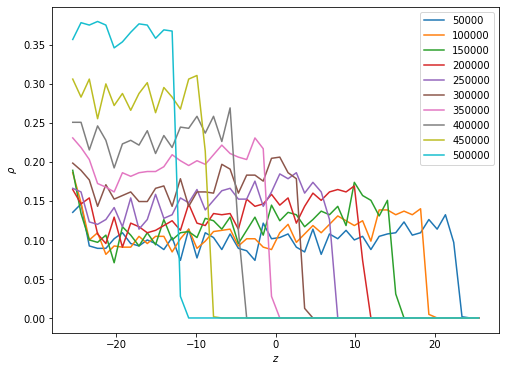

In [2]:
import numpy as np
import gsd.hoomd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(8,6))

# read gsd file
trajectory = gsd.hoomd.open(name='tutorial_02_implicit_evaporation_trajectory.gsd')

for frame in trajectory:
    pos = frame.particles.position
    hist, bins = np.histogram(pos[:,2],bins=50,range=(-0.5*frame.configuration.box[2],0.5*frame.configuration.box[2]))
    center = (bins[:-1] + bins[1:]) / 2
    volume_bin = (bins[1]-bins[0])*frame.configuration.box[0]*frame.configuration.box[1]
    ax.plot(center,hist/volume_bin,label=frame.configuration.step)

ax.set_xlabel('$z$')
ax.set_ylabel(r'$\rho$')
ax.legend()
plt.show()

The histograms are fairly noisy and you should repeat the same simulation with different seeds and then average them for better statistics. Because we set interface speed by the values in the ``hoomd.variant.linear_interp`` and the diffusion constants are set in the thermostat (`gamma`), Peclet number can be computed simply by $Pe_i = v H_\text{init}/D_i$, where $H_\text{init}$ is the inital film height. 

## Further reading

- Stratification Dynamics in Drying Colloidal Mixtures https://pubs.acs.org/doi/full/10.1021/acs.langmuir.7b00543

- Stratification in Drying Polymer–Polymer and Colloid–Polymer Mixtures https://pubs.acs.org/doi/full/10.1021/acs.langmuir.7b02074

- Influence of hydrodynamic interactions on stratification in drying mixtures https://aip.scitation.org/doi/full/10.1063/1.5031789
